# Seminário: Gradiente Descendente

Insper - Aprendizagem Estatística de Máquina 1

Felipe Viacava de Freitas

São Paulo, Novembro/2022

## Conteúdo abordado nesta apresentação

1. O que são métodos Numéricos
2. O Gradiente Descendente no contexto da regressão logística

## Bibliografia

Este seminário se embasa na disciplina de Aprendizagem Estatística de Máquina 1 e em duas outras fontes:

1. Métodos Numéricos para Engenharia, 7a edição. Disponível na biblioteca do Insper.

<img src="MNPE.jpg" alt="drawing" width="400"/>

2. Machine Learning (Stanford University). Curso online grátis disponível no Coursera (https://coursera.org/share/1bd100f620e35029edc3601672059494)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
%matplotlib inline

## 1) O que são métodos numéricos

_"Os métodos numéricos são técnicas pelas quais os problemas matemáticos são formulados de modo que possam ser resolvidos com operações aritméticas. Embora existam muitos tipos de métodos numéricos, eles têm uma característica em comum: invariavelmente envolvem um grande número de cálculos aritméticos tediosos. Não é nada surpreendente que, com o desenvolvimento de computadores digitais rápidos e eficientes, o papel dos métodos numéricos na resolução de problemas de engenharia tenha aumentado drasticamente nos últimos anos"_ -- Chapra

Os métodos numéricos são algoritmos iterativos que dependem apenas de operações aritméticas (somas, subtrações, logarítmos, expoentes e qualquer outra forma de manipulação __numérica__)

### Exemplo de aplicação: raiz quadrada

Um exemplo da necessidade de métodos numéricos na solução de problemas matemáticos: cálculo da raiz quadrada.

$ x = \sqrt{N}$

Na escola aprendemos a realizar quase todas as operações matemáticas, mas a solução da raiz quadrada sempre foi baseada na tentativa e erro. Fazer isso para um número que tem uma raiz inteira, como $x = \sqrt{4}$, é fácil. Mas e se quisermos a solução para $x = \sqrt{2}$?

É impossível encontrar o valor exato de $\sqrt{2}$, mas podemos chegar perto o suficiente para que o resultado seja aceitável. A estratégia se baseia em testar valores de $x$ até que seu quadrado seja próximo do valor de $N$.

### Como é calculada a raiz quadrada?

Um método popular para a solução de raízes de equações é o método de Newton-Raphson.

O método de Newton-Raphson determina que se repita $x_{i+1} = x_{i} - \frac{f(x_{i})}{f'(x_{i})}$, até que o critério de parada $|\frac{x_{i+1} - x_{i}}{x_{i}}| <= E$ seja satisfeito (sendo $E$ uma constante definida arbitrariamente)

Para $x = \sqrt{N}$, temos $x^{2} = N$

Logo, queremos encontrar a raiz da equação $f(x) = N - x^{2}$

Assim, temos:

$ x_{i+1} = \frac{x_{i} + \frac{N}{x_{i}}}{2}$

Assumindo um valor inicial de $x = N$ e $E = 0.0001$, implemetamos o método no bloco de código abaixo.

In [2]:
def sqrt(N,E):

    x0 = N
    i = 0

    x0l = []
    x1l = []
    el = []

    while True:
        
        x1 = (x0 + (N/x0 )) / 2
        e = abs((x1-x0)/x0)

        x0l.append(x0)
        x1l.append(x1)
        el.append(e)

        if e <= E:
            break

        x0 = x1
    
    nr_df = pd.DataFrame(data=np.array([x0l,x1l,el]).transpose(), columns=['x0','x01','Erro'])

    r = {'N':N, 'Tolerância':E, 'Número de iterações':len(nr_df), 'Raiz encontrada':x0}
    return {'Resultados': r, 'Dados': nr_df}

In [3]:
r100 = sqrt(16,0.0001)
r = r100['Resultados']
r

{'N': 16,
 'Tolerância': 0.0001,
 'Número de iterações': 6,
 'Raiz encontrada': 4.000000636692939}

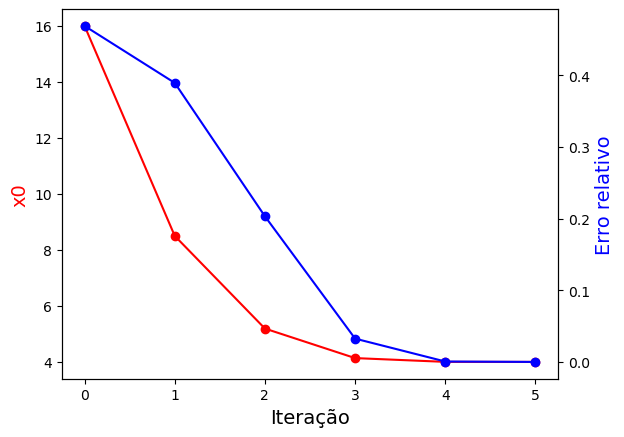

In [4]:
df = r100['Dados']
fig,ax = plt.subplots()
ax.plot(range(len(df)),df['x0'],color="red", marker="o")
ax.set_xlabel("Iteração", fontsize = 14)
ax.set_ylabel("x0",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(range(len(df)), df['Erro'],color="blue",marker="o")
ax2.set_ylabel("Erro relativo",color="blue",fontsize=14)
plt.show()

## 2) O Gradiente Descendente no contexto da regressão logística

Aprendemos nesta disciplina a utilizar a regressão logística para classificação binária.

$\ h(y=1|x;\theta) = \frac{1}{1+e^{-x\theta}}$

Se $\ h(y=1|x;\theta) >= c$, então $\hat{y} = 1$

Se $\ h(y=1|x;\theta) < c$, então $\hat{y} = 0$

Aqui, implementaremos o método numérico que os frameworks de machine learning utilizam para encontrar os estimadores \theta.

Utilizando a biblioteca NumPy, podemos vetorizar as operações, otimizando o uso do processador. Assim, a matriz de elementos $x$ será representada por $X$, a de $y$ por $Y$, etc.

$h(X=1|X,\theta) = \frac{1}{1+e^{-X\theta}}$

Se $\ h_{i}(y_{i}|x_{i};\theta) >= c$, então $\hat{y_{i}} = 1$

Se $\ h_{i}(y_{i}|x_{i};\theta) < c$, então $\hat{y_{i}} = 0$

Os dados utilizados serão os mesmos do laboratório 2: a base de dados com informações sobre diferentes vinhos brancos:

https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

Como desejamos implementar o método em um algoritmo de classificação, começamos manipulando a variável de interesse para transforma-la de uma variável contínua em uma variável binária

In [5]:
df = pd.read_csv('wine.csv',sep=';', decimal=',')
df['quality'] = df['quality'].apply(lambda quality: 0 if quality < 6 else 1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


### Treinamento do modelo

Sendo $X$ uma função de dimensões $(m,n)$, $Y$ uma matrix de dimensões $(m,1)$ e $\theta$ uma matrix de dimensões $(n,1)$

O erro das estimativas é dado por:

$J(\theta) = \frac{1}{m} \sum \limits _{i=1} ^{m} {J(x_{i},h_{\theta}(x_{i}))}$

$J(x_{i},h_{\theta}(x_{i})) = -ln(h_{\theta}(x_{i}))$ se $y_{i} = 1$

$J(x_{i},h_{\theta}(x_{i})) = -ln(1-h_{\theta}(x_{i}))$ se $y_{i} = 0$

<img src="cost1.jpeg" alt="drawing" width="400"/>

A imagem do curso online do Coursera mostra que:

$J(h_{\theta}(x_{i}, y_{i}) = 0$ se $h_{\theta}(x_{i}) = y_{i}$

$J(h_{\theta}(x_{i}, y_{i})) \rightarrow \infty$ se $h_{\theta}(x_{i}) = 0$ e $y_{i} = 1$

$J(h_{\theta}(x_{i}, y_{i})) \rightarrow \infty$ se $h_{\theta}(x_{i}) = 1$ e $y_{i} = 0$

Em uma função computável:

$J(\theta) = \frac{1}{m} \sum \limits _{i=1} ^{m} [-y_{i}*ln(h_{\theta}(x_{i}))-(1-y_{i})*ln(1-h_{\theta}(x_{i}))]$

Ou na forma matricial:

$J(\theta) = \frac{1}{m}[-Y^{T}*ln(H_{\theta}(X))-(1-Y)^{T}*ln(1-H_{\theta}(X))]$

Como minimizar esta função J?

Basta utilizar o Gradiente Descendente!

Primeiro, inicializamos a matrix $\theta_{m,n}$ com valores $\theta_{i,j} = 0$

Então, repete-se até a convergência:

- $Z(X,\theta) = X*\theta$

- $H_{\theta}(Z) = \frac{1}{1+e^{-Z}}$

- $\frac{\partial J}{\partial \theta} = \frac{1}{m}X^{T}[H_{\theta}(Z)-Y]$

- $\theta := \theta - \alpha*\frac{\partial J}{\partial {\theta}}$

Sendo $\alpha$ (learning rate) um hyperparâmetro ajustado encontrar uma melhor performance do algoritmo.

In [6]:
##### Funções relacionadas ao treinamento do modelo #####

def fit_logreg(X,Y,alpha=10**-4, max_iter = 10**4):
    '''
    Retorna array de parâmetros preditores theta de dimensão (n,1)
    Plota convergência do método do gradiente descentente aplicado à regressão logística
    
    X: Array de variáveis preditoras de dimensão (m,n)
    Y: Array da variável de interesse de dimensão (m,1)
    alpha: learning rate
    max_iter: número máximo de iterações
    '''
    J_history = []
    theta = initialize_theta(X)
    
    for i in range(max_iter):
        P = predict_P(X,theta)
        J_history.append(calculate_cost(P,Y))
        theta = theta + alpha*gradient(X,P,Y)

    plot_convergence(J_history,alpha)
    return theta

def gradient(X,P,Y):
    '''
    Retorna array de gradientes dos parâmetros preditores theta de dimensão (n,1)

    X: Array de variáveis preditoras de dimensão (m,n)
    Y: array da variável de interesse de dimensão (m,1)
    '''
    m = X.shape[0]
    dJ = -(1/m)*np.dot(X.transpose(),(P-Y))
    return dJ

def predict_P(X,theta):
    '''
    Retorna array de previsões de uma regressão logística de dimensão (m,1)

    X: Array de variáveis preditoras de dimensão (m,n)
    theta: array de parâmetros preditores de dimensão (n,1)
    '''
    Z = np.dot(X,theta)
    P = 1/(1+(np.exp(-Z)))
    return P

def initialize_theta(X):
    '''
    Retorna array de parâmetros theta de dimensões (n,1)
    
    X: Array de variáveis preditoras de dimensão (m,n)
    '''
    n = X.shape[1]
    theta = np.zeros((n,1))
    return theta

def calculate_cost(P,Y):
    '''
    Retorna float do erro das previsões de um modelo
    
    P: Array de previsões de dimensão (m,1)
    Y: Array da variável de interesse de dimensão (n,1)
    '''
    m = P.shape[0]
    j1 = -np.dot(Y.transpose(),np.log(P))
    j2 = -np.dot((1-Y).transpose(),np.log(1-P))
    J = (j1+j2)/m
    return J

def plot_convergence(J_history,alpha):
    '''
    Plota convergência do método do gradiente descentente aplicado à regressão logística

    J_history: lista de valores de erro
    alpha: valor do learning rate utilizado
    '''
    plt.scatter(range(len(J_history)),J_history,color='blue',label='Train Error',s=0.1)
    plt.title(f'alpha = {alpha}')
    plt.ylabel('Erro')
    plt.xlabel('Iteração')
    plt.show()

In [7]:
##### Funções relacionadas ao conjunto de dados #####

def splitXY(df,Y_label='quality'):
    '''
    Divide o dataset entre X e Y

    df: DataFrame pandas
    Y_label: nome da coluna da variável de interesse
    '''
    X = df.drop([Y_label],axis=1).values
    Y = df['quality'].values.reshape((len(df),1))
    return X,Y

def add_bias(X):
    '''
    Adiciona colunas de intercepto ao conjunto de variáveis preditoras

    X: array numpy
    '''
    X = np.column_stack([np.ones((X.shape[0],1)),X])
    return X

C:\Users\fevif\AppData\Local\Temp\ipykernel_13108\2912528495.py:65: RuntimeWarning: divide by zero encountered in log
  j2 = -np.dot((1-Y).transpose(),np.log(1-P))
C:\Users\fevif\AppData\Local\Temp\ipykernel_13108\2912528495.py:43: RuntimeWarning: overflow encountered in exp
  P = 1/(1+(np.exp(-Z)))
C:\Users\fevif\AppData\Local\Temp\ipykernel_13108\2912528495.py:64: RuntimeWarning: divide by zero encountered in log
  j1 = -np.dot(Y.transpose(),np.log(P))


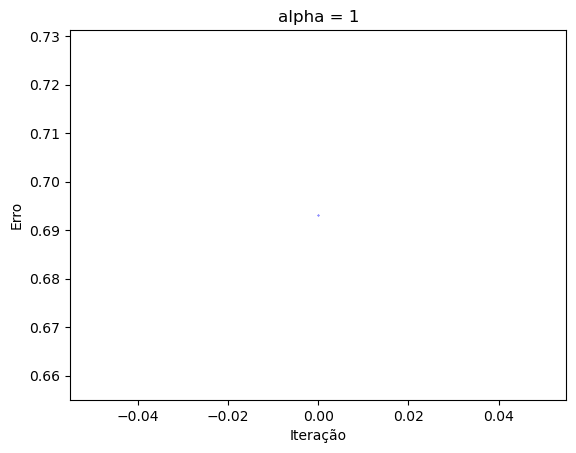

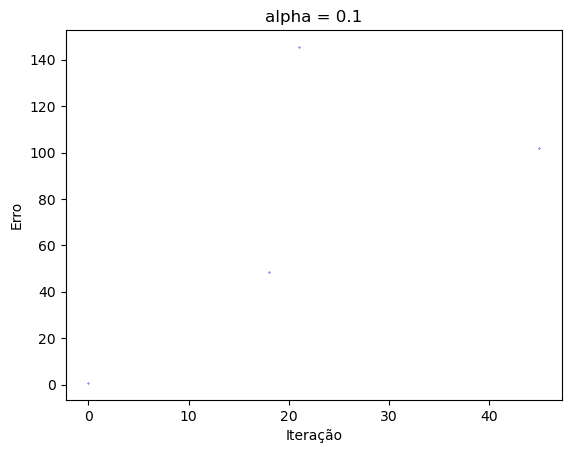

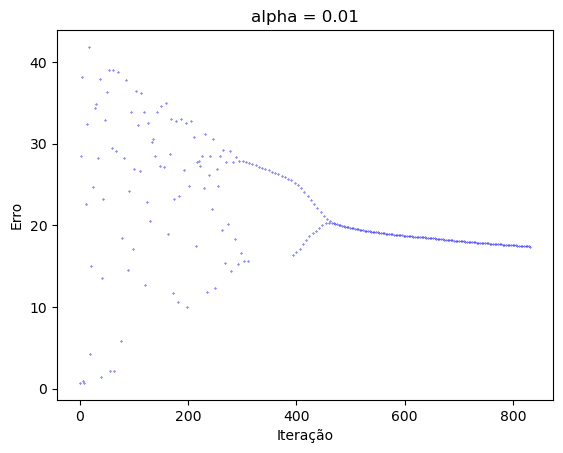

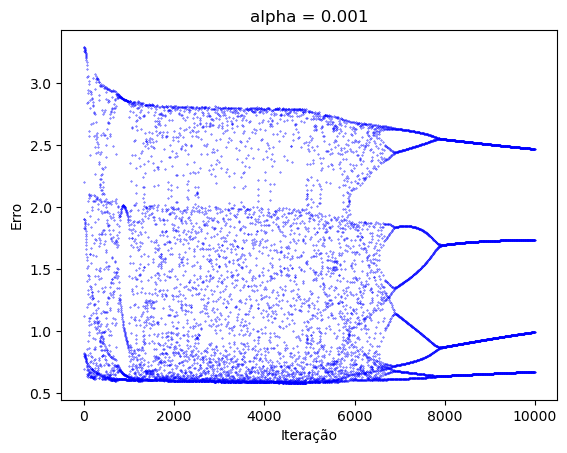

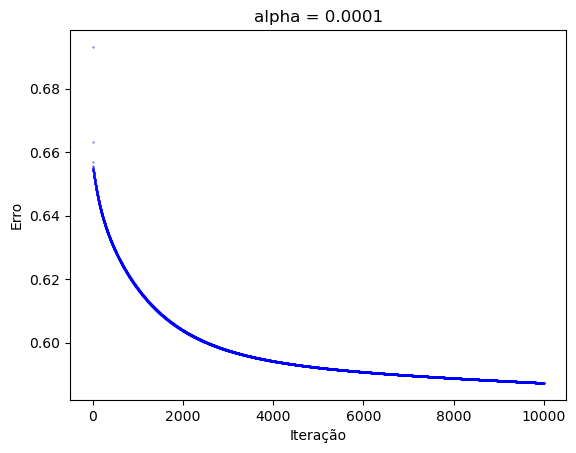

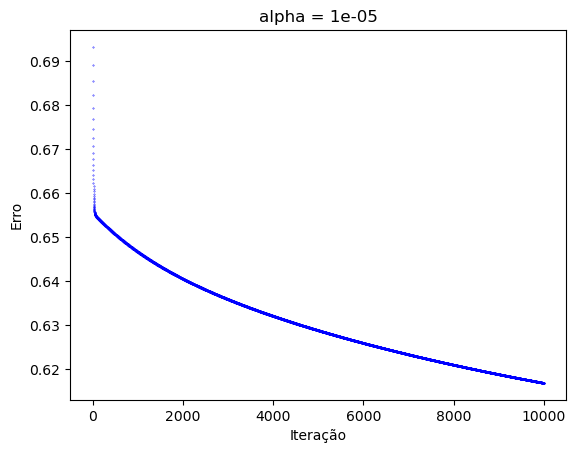

In [8]:
X,Y = splitXY(df)
X = add_bias(X)

for i in range(0,6):
    theta = fit_logreg(X,Y,alpha=10**-(i))

A importância de compreender como funciona o gradiente decorre não da necessidade de programá-lo manualmente quando se deseja utilizar uma regressão logística (afinal, os frameworks como SciKitLearn e TensorFlow são muito performáticos e inteligentes), mas de como um pré-processamento de dados pode _possibilitar_ o uso de algum modelo que parecia não se ajustar aos seus dados.

A falta de convergência nos cenários em que $\alpha >= 0.001$ acima acontece porque a taxa de aprendizagem é muito alta, ou seja, quando a matriz $\theta$ é corrigida a cada iteração, a correção é tão grande que os valores $\theta$ "passam do ponto" e o erro é ainda maior. Isso se repete até o programa atingir o numéro máximo de iterações estabelecido.

Contudo, usar um $\alpha$ muito baixo torna o tempo de convergência muito alto -- com $\alpha = 0.001$ o algoritmo converge 1000 vezes mais devagar que com $\alpha = 1$, o que em um modelo em produção pode ter muitas consequências ruins -- , então, precisamos manipular as variáveis preditoras para que valores de $\alpha$ mais altos também garantam convergência.

### Pré-processamento dos dados: como acelerar o convergência?

Neste exemplo, utilizaremos um método simples e muito eficaz para melhorar a convergência do gradiente descendente: Standard Scaling.

Este método consiste em calcular a média de cada variável preditora em todas suas observações e, então, subtraí-la do conjunto de treino inicial, trazendo sua nova média para 0.

Num modelo real, os conjuntos de treino e teste devem ser separados antes deste processo. Assim, são calculadas as médias das variáveis no conjunto de treino para então subtraí-las tanto do conjunto de treino quanto do conjunto de teste.

In [9]:
##### Funções relacionadas ao conjunto de dados #####

def standardize(X):
    '''
    Ajusta o StandardScaler a X e retorna X de variáveis preditoras de média 0.

    X: Array de variáveis preditoras, com a coluna de indice 0 assumindo apenas valores iguais a 1 obrigatoriamente
    '''
    ss = StandardScaler()
    ss.fit(X[:,1:])
    X[:,1:] = ss.transform(X[:,1:])

    return X

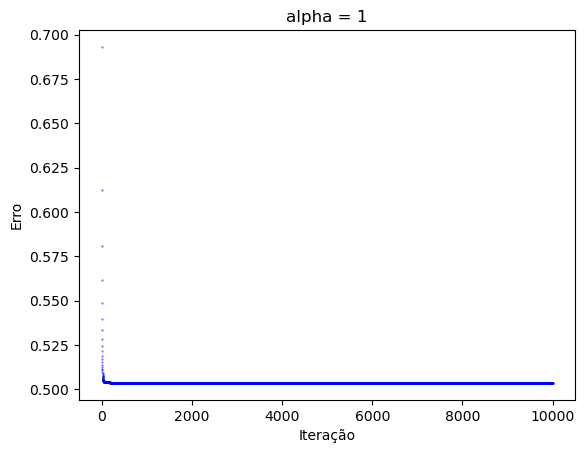

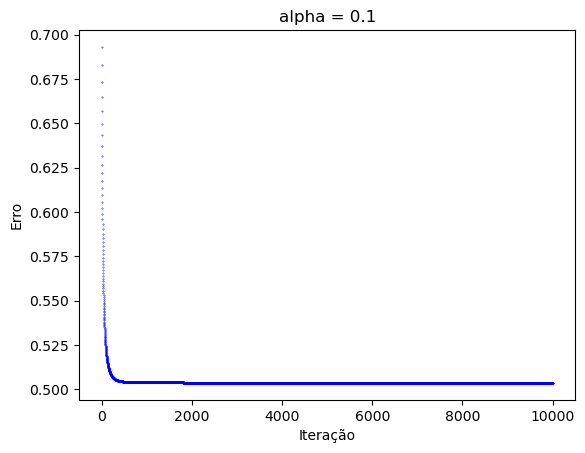

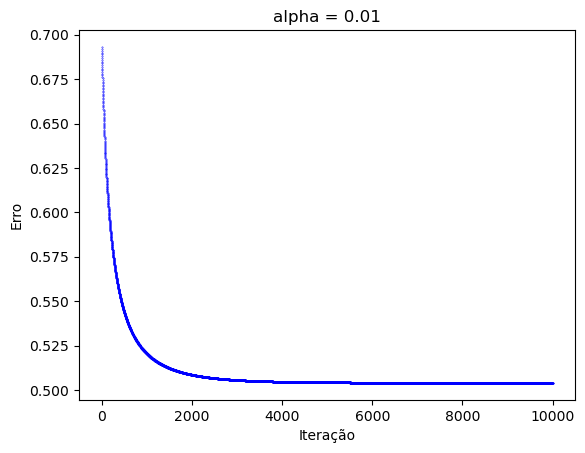

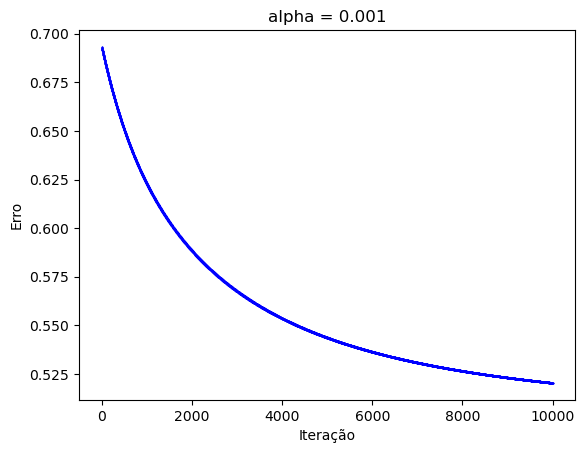

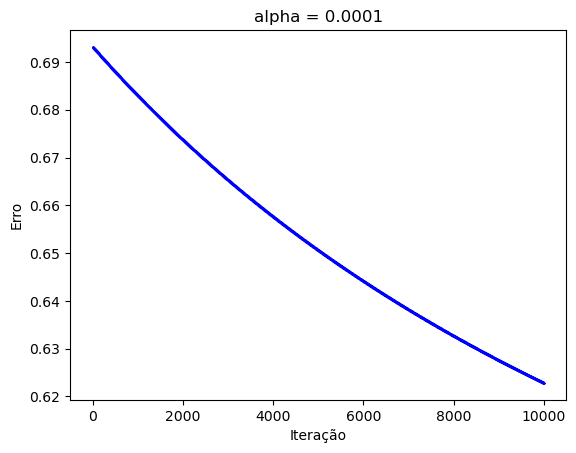

In [10]:
X,Y = splitXY(df)
X = add_bias(X)
X = standardize(X)

for i in range(5):
    theta = fit_logreg(X,Y,alpha=10**-(i),max_iter=10**4)

Podemos perceber que, com o StandardScaler, o modelo converge até quando $\alpha = 1$. Assim, temos um programa muito mais performático e possivelmente aplicável em larga escala.

### Testando o método implementado

Nesta seção, separamos o dataset entre treino e teste, treinamos o modelo novamente (agora com o alpha definido e mais iterações) e comparamos a array de thetas e a AUC entre o algoritmo autoral e o do sklearn

In [11]:
##### Funções relacionadas à manipulação do conjunto de dados #####

def standardize_train_test(X_train,X_test):
    '''
    Ajusta o StandardScaler a X_train e manipula X_train e X_test.

    X_train e X_test: Arrays de variáveis preditoras, com a coluna de indice 0 assumindo apenas valores iguais a 1 obrigatoriamente
    '''
    ss = StandardScaler()
    ss.fit(X_train[:,1:])
    X_train[:,1:] = ss.transform(X_train[:,1:])
    X_test[:,1:] = ss.transform(X_test[:,1:])

    return X_train, X_test

In [12]:
##### Funções relacionadas à predição #####

def classify_p(p,c):
    '''
    Transforma um valor em binário

    p: valor real a ser transformado
    c: valor real para determinar a classificação
    '''
    return 0 if p < c else 1

def classify(P,c=0.5):
    '''
    Aplica a função classify_p em uma array

    P: array de valores reais
    c: valor real para determinar a classificação
    '''
    Y_pred = np.vectorize(classify_p)(P,c)
    return Y_pred

In [13]:
##### Funções relacionadas à visualização dos resultados #####

def plot_roc_curve(Y_test, P,title):
    """
    Plota a ROC

    Y_test: array com valores observados
    P: array com valores preditos
    """

    fpr, tpr, thresholds = roc_curve(Y_test, P)
    plt.plot(fpr, tpr,label=title)
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

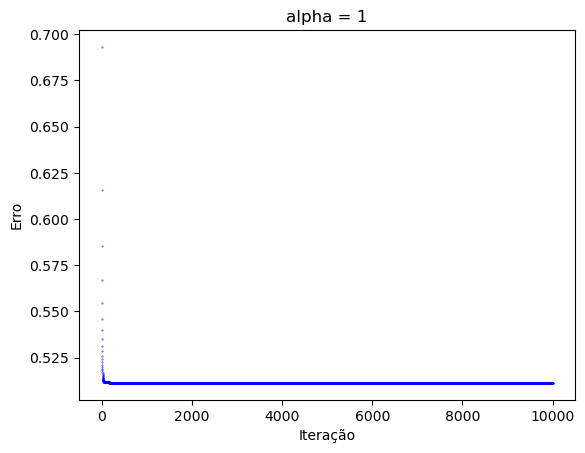

In [14]:
X,Y = splitXY(df)
X = add_bias(X)

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20,random_state=123)

X_train, X_test = standardize_train_test(X_train,X_test)

theta = fit_logreg(X_train,Y_train,alpha=10**-0,max_iter=10**4)

In [15]:
skmodel = LogisticRegression()
skmodel.fit(X_train,Y_train)

compare_theta = pd.DataFrame()
compare_theta['sklearn'] = skmodel.coef_[0]
compare_theta['GD'] = theta
compare_theta['Relative Difference'] = abs((compare_theta['sklearn']-compare_theta['GD'])/compare_theta['GD'])
compare_theta.head(len(compare_theta))

c:\Users\fevif\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,sklearn,GD,Relative Difference
0,0.000020,0.881116,0.999978
1,-0.008797,0.000102,87.526564
2,-0.617143,-0.618754,0.002604
3,0.010062,0.010262,0.019513
4,0.824738,0.854256,0.034554
5,0.027567,0.029988,0.080722
6,0.166707,0.165391,0.007958
7,-0.063042,-0.060593,0.040421
8,-0.723791,-0.766867,0.056171
9,0.147990,0.155628,0.049078


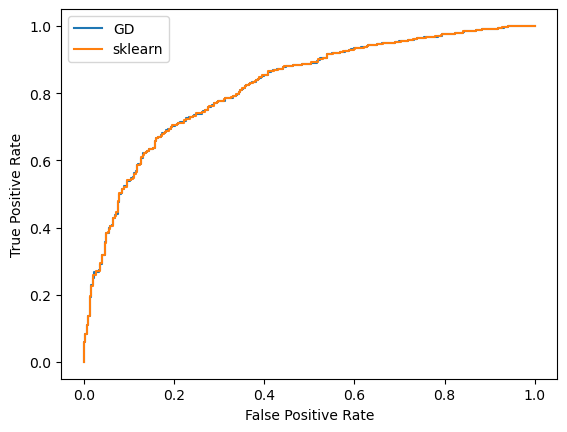

In [16]:
P = predict_P(X_test,theta)
Psk = skmodel.predict_proba(X_test)
Psk = [line[1] for line in Psk]

plot_roc_curve(Y_test,P,'GD')
plot_roc_curve(Y_test,Psk,'sklearn')

In [17]:
# AUC do modelo do sklearn e do gradiente descendente implementado

print(f'AUC do GD: {roc_auc_score(Y_test,P):.4f}')
print(f'AUC do sklearn: {roc_auc_score(Y_test,Psk):.4f}')

AUC do GD: 0.8203
AUC do sklearn: 0.8204


In [18]:
# Erro médio absoluto entre predições do sklearn e do gradiente descendente implementado

Y_predsk =  skmodel.predict(X_test)
Y_pred = np.array([1 if i >= 0.5 else 0 for i in P])
Y_diff = sum(abs(Y_pred-Y_predsk))
Y_diff/len(Y_pred)

0.0

Como validação do algoritmo implementado, na célula acima comparamos o nosso modelo com o modelo do scikitlearn usando o erro médio absoluto e percebemos que nenhuma das predições no conjunto de testes é diferente entre eles considerando um corte de classificação de 0.5.